In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import joblib
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
raw_features = 992

In [3]:
# === Step 1: Load data ===
df = pd.read_excel('2. Dataset Tampere.xlsx')  # Replace with your actual filename
# Load test data
DT = pd.read_excel('2. Datatest Tampere.xlsx')  # unseen data

# Pre-processing

In [4]:
# Linear Normalization to [0,1] Using Dataset Minimum

'''rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute minimum RSSI value (exclude 0s from consideration)
# Only consider values < 0 (i.e., actual signal readings), ignore 0 (no signal)
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 4: Apply linear normalization
# Keep 0s as 0 (representing no signal), and normalize only values < 0
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: 0 if x >= 0 else (x - rssi_min) / -rssi_min
)
df'''

# Powered Normalization Using Dataset Minimum

'''rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first raw_features columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute dataset-wide minimum RSSI (only for real signal values, excluding 0) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 4: Apply powered normalization (exclude 0 from normalization) ===
gamma = 2  # you can change this exponent as needed

df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: ((x - rssi_min) / -rssi_min) ** gamma if x < 0 else 0
)

df'''

# Min-Max Normalization Using Global Min/Max

'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute dataset-wide min and max RSSI values (excluding 0s) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
rssi_max = df[rssi_columns][df[rssi_columns] < 0].max().max()

# === Step 4: Apply Min-Max Normalization to [0, 1] (exclude 0 from normalization) ===
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: (x - rssi_min) / (rssi_max - rssi_min) if x < 0 else 0
)

df'''

# Powered Transformation After Per-Fingerprint Normalization

'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Convert RSSI to positive by shifting (only for non-zero values)
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
shift = rssi_min - 1

# Shift only values less than 0, leave 0s unchanged
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 4: Per-row (fingerprint) normalization (excluding 0s) ===
# Normalize each row based on the max of non-zero entries
row_max = df[rssi_columns].replace(0, pd.NA).max(axis=1)

df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 5: Apply powered transformation (e.g., square) only to non-zero values
gamma = 2  # You can set this to any exponent like e, 1.5, etc.
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x**gamma if x > 0 else 0)'''

# Sigmoid-Scaled Row Normalization

# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features] 

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Shift RSSI to positive (only non-zero) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
shift = rssi_min - 1  # shift negative RSSI to positive
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 4: Row-wise normalization (exclude zeros) ===
row_max = df[rssi_columns].replace(0, pd.NA).max(axis=1)
df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 5: Apply sigmoid transformation to non-zero values ===
alpha = 10
beta = 0.5
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_6576\2724756925.py:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_6576\2724756925.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_6576\2724756925.py:102: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(


In [5]:
# Linear Normalization to [0,1] Using Dataset Minimum

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse the dataset-wide minimum RSSI value from training ===
# Ensure `rssi_min` is defined from the training set beforehand
# rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 3: Apply the linear normalization formula (excluding 0s) ===
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: 0 if x >= 0 else (x - rssi_min) / -rssi_min
)
DT'''

# Powered Normalization Using Dataset Minimum

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse the dataset-wide minimum RSSI value from training ===
# Make sure `rssi_min` is defined and matches the one used during training:
# Example:
# rssi_min = -104

# === Step 3: Apply powered normalization (exclude 0 from normalization) ===
gamma = 2  # Power factor (can also use math.e or another value)

DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: ((x - rssi_min) / -rssi_min) ** gamma if x < 0 else 0
)

DT'''

# Min-Max Normalization Using Global Min/Max

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse dataset-wide min and max RSSI values from training ===
# Ensure rssi_min and rssi_max were saved during training:
# Example:
# rssi_min = -104
# rssi_max = -30

# === Step 3: Apply Min-Max Normalization to [0, 1] (exclude 0 from normalization) ===
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: (x - rssi_min) / (rssi_max - rssi_min) if x < 0 else 0
)

DT'''

# Powered Transformation After Per-Fingerprint Normalization

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse dataset-wide minimum RSSI value from training to shift into positive range
# Make sure `rssi_min` is defined (e.g., rssi_min = -104)
shift = rssi_min - 1

# Shift only real RSSI values (< 0), leave 0s untouched
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 3: Normalize each fingerprint row-wise to [0, 1], excluding 0s ===
row_max = DT[rssi_columns].replace(0, pd.NA).max(axis=1)
DT[rssi_columns] = DT[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 4: Apply powered transformation only to non-zero values ===
#gamma = 2  # You can adjust this exponent as needed
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x**gamma if x > 0 else 0)

DT'''

# Sigmoid-Scaled Row Normalization


# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Shift RSSI using dataset-wide min (from training) ===
shift = rssi_min - 1
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 3: Row-wise normalization (exclude zeros) ===
row_max = DT[rssi_columns].replace(0, np.nan).max(axis=1)
DT[rssi_columns] = DT[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 4: Apply sigmoid transformation ===
alpha = 10
beta = 0.5 
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_6576\2385938150.py:84: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_6576\2385938150.py:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(


In [6]:
X = df.iloc[:,:raw_features]
X_target = DT.iloc[:,:raw_features]

y_floor = df.iloc[:, -1]
y_coordinate = df.iloc[:, [-3,-2]]
y_target_floor = DT.iloc[:,-1]
y_target_coordinate = DT.iloc[:, [-3,-2]]

# Important Features

In [7]:
# Confidence weighting using Pearson correlation

# Step 6.1: Compute Pearson correlations between each feature and target
correlations = X.apply(lambda x: x.corr(y_floor), axis=0)

# Step 6.2: Replace NaN with 0
correlations = correlations.fillna(0)

# Step 6.3: Compute confidence weights
confidence_weights = correlations.abs()

# Optional: scale weights to [0, 1]
confidence_weights = confidence_weights / confidence_weights.max()

# Step 6.4: Multiply each feature by its confidence weight
X_weighted = X.mul(confidence_weights, axis=1)

C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# Confidence weighting using Pearson correlation

# Step 6.5: Remove all-zero columns
X_weighted_cleaned = X_weighted.loc[:, (X_weighted != 0).any(axis=0)]

# Step 6.6: Update feature count
raw_features = X_weighted_cleaned.shape[1]

# Result: X_weighted_cleaned has transformed, normalized, and confidence-weighted features
X_weighted_cleaned

,rss1,rss2,rss4,rss6,rss7,rss8,rss9,rss10,rss11,rss12,...,rss978,rss979,rss980,rss981,rss983,rss986,rss988,rss989,rss991,rss992
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.127680,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.008991,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.0,0.000000,0.0,0.0,0.205481,0.08294,0.221649,0.078122,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Confidence weighting using Pearson correlation

# Step 2: Apply the same weights to X_target
X_target_weighted = X_target.mul(confidence_weights, axis=1)

# Step 3: Keep only the columns that were kept in training
X_target_weighted_cleaned = X_target_weighted[X_weighted_cleaned.columns]

X_target_weighted_cleaned

,rss1,rss2,rss4,rss6,rss7,rss8,rss9,rss10,rss11,rss12,...,rss978,rss979,rss980,rss981,rss983,rss986,rss988,rss989,rss991,rss992
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.22271,0.0,0.214504,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3947,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3948,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [10]:
X = X_weighted_cleaned
X_target = X_target_weighted_cleaned

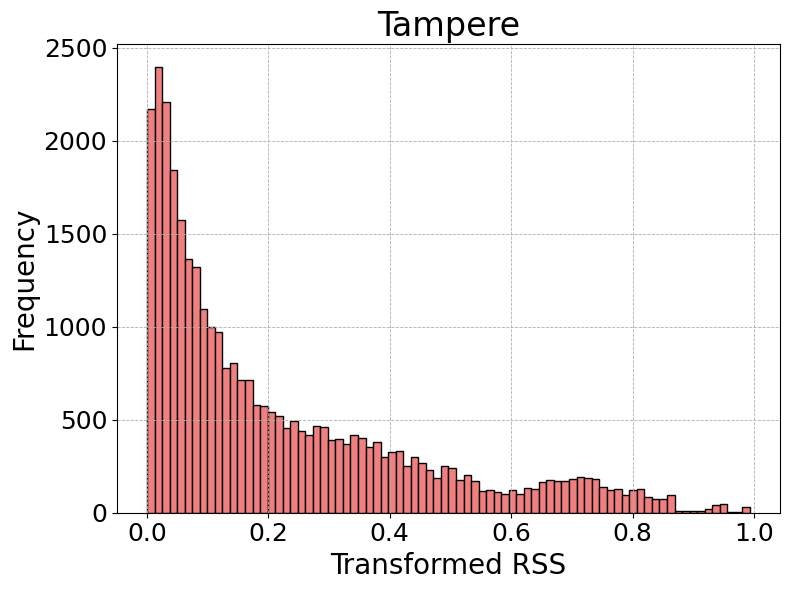

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
#raw_features = 992
#df = pd.read_excel('2. Dataset Tampere.xlsx')
#X = df.iloc[:, :raw_features]

# Flatten all values into a single array
all_values = X.values.flatten()

# Remove NaNs and values equal to 100
all_values = all_values[~pd.isnull(all_values)]
all_values = all_values[all_values != 0]  # <-- Exclude 100

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
ax.hist(all_values, bins=80, color='lightcoral', edgecolor='black', zorder=1)

# Grid behind
ax.grid(True, linestyle='--', linewidth=0.6, zorder=1)

# Titles and labels
ax.set_title("Tampere", fontsize=24)
ax.set_xlabel("Transformed RSS", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)

# Adjust tick font sizes
ax.tick_params(axis='both', labelsize=18)
plt.tight_layout()
plt.savefig('Transformed Tampere distribution.svg', dpi = 600)
plt.show()

# Floor Prediction

In [13]:
import optuna
import random
import numpy as np
from optuna.exceptions import TrialPruned
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [14]:
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_floor, test_size=0.2, random_state=42)

# --- Fix random seeds for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [15]:
import time
import numpy as np
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

start_time1 = time.time()

# --- Custom weight function for KNN ---
def knn_weight(d):
    return 1 / (d + 1e-6) ** 2


# --- Objective function for KNN ---
def objective_wknn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=knn_weight,
        p=p,
        metric=metric
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for RandomForest ---
def objective_rf(trial):
    rf = RandomForestClassifier(
        max_depth=trial.suggest_categorical('max_depth', [None] + list(range(5, 51))),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for LightGBM ---
def objective_lgb(trial):
    param = {
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'random_state': SEED,
        'verbosity': -1,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_error',
            callbacks=[lgb.early_stopping(100)]
        )

        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for XGBoost ---
def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_float('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 0, 5),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        eval_metric='mlogloss',
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for GaussianNB ---
def objective_gnb(trial):
    model = GaussianNB(
        var_smoothing=trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for AdaBoost ---
def objective_adaboost(trial):
    base_estimator = DecisionTreeClassifier(
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        max_depth=trial.suggest_int('max_depth', 1, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        random_state=SEED
    )

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        random_state=SEED
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)

In [16]:
# KNN
# --- Run the optimization ---
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_wknn, n_trials=100, timeout=300)

# --- Get best parameters ---
best_params1 = study1.best_params
print("Best KNN hyperparameters:", best_params1)

# --- Train final model ---
knn_floor_final = KNeighborsClassifier(
    n_neighbors=best_params1['n_neighbors'],
    weights=knn_weight,
    p=best_params1['p'],
    metric=best_params1['metric']
)

# --- Cross-validation accuracy ---
cv_scores_knn = cross_val_score(knn_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("KNN Cross-val Accuracies:", cv_scores_knn)
print("KNN Mean CV Accuracy:", cv_scores_knn.mean())

# --- Train on full training set ---
knn_floor_final.fit(X_train, y_train)
joblib.dump(knn_floor_final, 'knn_floor_Tampere.joblib')




# Random Forest
# --- Run the optimization ---
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_rf, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params2 = study2.best_params
print("Best Random Forest hyperparameters:", best_params2)

rf_floor_final = RandomForestClassifier(
    **best_params2,
    random_state=SEED,
    n_jobs=-1
)

# --- Cross-validation accuracy ---
cv_scores_rf = cross_val_score(rf_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("RF Cross-val Accuracies:", cv_scores_rf)
print("RF Mean CV Accuracy:", cv_scores_rf.mean())

# --- Train on full training set ---
rf_floor_final.fit(X_train, y_train)
joblib.dump(rf_floor_final, 'rf_floor_pred_Tampere.joblib')

[I 2025-12-20 12:45:30,088] A new study created in memory with name: no-name-338be68d-4304-4a3f-9e00-78306d1f43b2
[I 2025-12-20 12:45:34,940] Trial 0 finished with value: 0.8329954954954955 and parameters: {'n_neighbors': 41, 'p': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8329954954954955.
[I 2025-12-20 12:45:37,724] Trial 1 finished with value: 0.8366312741312741 and parameters: {'n_neighbors': 29, 'p': 5, 'metric': 'euclidean'}. Best is trial 1 with value: 0.8366312741312741.
[I 2025-12-20 12:45:40,244] Trial 2 finished with value: 0.8886743886743886 and parameters: {'n_neighbors': 15, 'p': 4, 'metric': 'manhattan'}. Best is trial 2 with value: 0.8886743886743886.
[I 2025-12-20 12:45:43,853] Trial 3 finished with value: 0.8527348777348778 and parameters: {'n_neighbors': 14, 'p': 3, 'metric': 'minkowski'}. Best is trial 2 with value: 0.8886743886743886.
[I 2025-12-20 12:45:46,572] Trial 4 finished with value: 0.8743243243243242 and parameters: {'n_neighbors': 25, 'p': 3

Best KNN hyperparameters: {'n_neighbors': 4, 'p': 1, 'metric': 'manhattan'}


[I 2025-12-20 12:50:19,093] A new study created in memory with name: no-name-627fc659-8d6d-449a-93b3-1969ef1264e4


KNN Cross-val Accuracies: [0.96428571 0.85714286 0.98214286 0.94642857 0.89285714 0.875
 0.91071429 0.85454545 0.90909091 0.81818182]
KNN Mean CV Accuracy: 0.9010389610389609


[I 2025-12-20 12:50:29,013] Trial 0 finished with value: 0.7629504504504505 and parameters: {'max_depth': 5, 'n_estimators': 197, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.7629504504504505.
[I 2025-12-20 12:50:39,147] Trial 1 finished with value: 0.8599099099099099 and parameters: {'max_depth': 44, 'n_estimators': 329, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8599099099099099.
[I 2025-12-20 12:50:47,866] Trial 2 finished with value: 0.8312419562419562 and parameters: {'max_depth': 34, 'n_estimators': 95, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.8599099099099099.
[I 2025-12-20 12:51:02,191] Trial 3 finished with value: 0.820447232947233 and parameters: {'max_depth': 45, 'n_estimators': 485, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.8599099099099099.
[I

Best Random Forest hyperparameters: {'max_depth': 47, 'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}


C:\Users\KMITL\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF Cross-val Accuracies: [0.96428571 0.92857143 0.91071429 0.92857143 0.91071429 0.89285714
 0.875      0.90909091 0.96363636 0.8       ]
RF Mean CV Accuracy: 0.9083441558441558


['rf_floor_pred_UJI.joblib']

In [17]:
# Run Optuna study
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_lgb, n_trials=100, timeout=300)

# Best params
best_params3 = study3.best_params
print("Best LightGBM hyperparameters:", best_params3)

best_params3.update({
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train))
})

# Final model
lgb_floor_final = lgb.LGBMClassifier(**best_params3)

# Cross-validation
cv_scores_lgb = cross_val_score(lgb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("LGB Cross-val Accuracies:", cv_scores_lgb)
print("LGB Mean CV Accuracy:", cv_scores_lgb.mean())

# Train final model
lgb_floor_final.fit(X_train, y_train)

# Save
joblib.dump(lgb_floor_final, 'lgb_floor_pred_Tampere.joblib')

[I 2025-12-20 12:55:50,025] A new study created in memory with name: no-name-fc5e9d39-2267-4114-8c89-a1772abdb4cd


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's multi_error: 0.1875	valid_0's multi_logloss: 0.488501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's multi_error: 0.196429	valid_0's multi_logloss: 0.678973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's multi_error: 0.198198	valid_0's multi_logloss: 0.549958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's multi_error: 0.279279	valid_0's multi_logloss: 0.80189
Training until validation scores don't improve for 100 rounds


[I 2025-12-20 13:03:03,688] Trial 0 finished with value: 0.7718629343629344 and parameters: {'learning_rate': 0.025665047234812447, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 75}. Best is trial 0 with value: 0.7718629343629344.


Early stopping, best iteration is:
[155]	valid_0's multi_error: 0.279279	valid_0's multi_logloss: 0.695577
Best LightGBM hyperparameters: {'learning_rate': 0.025665047234812447, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 75}
LGB Cross-val Accuracies: [0.875      0.85714286 0.80357143 0.80357143 0.76785714 0.73214286
 0.69642857 0.72727273 0.81818182 0.76363636]
LGB Mean CV Accuracy: 0.7844805194805196


['lgb_floor_pred_UJI.joblib']

In [18]:
# XGBoost
# --- Run optimization ---
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective_xgb, n_trials=100, timeout=300)

# --- Best parameters ---
best_params4 = study4.best_params
print("Best XGBoost hyperparameters:", best_params4)

# --- Train final model with best params ---
xgb_floor_final = XGBClassifier(**best_params4, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)

# --- Cross-validation accuracy ---
cv_scores_xgb = cross_val_score(xgb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("XGB Cross-val Accuracies:", cv_scores_xgb)
print("XGB Mean CV Accuracy:", cv_scores_xgb.mean())

# --- Train on full training set ---
xgb_floor_final.fit(X_train, y_train)
joblib.dump(xgb_floor_final, 'xgb_floor_pred_Tampere.joblib')

[I 2025-12-20 13:03:08,708] A new study created in memory with name: no-name-170cbb0e-027f-4846-b2ce-9c8f7c77bfe9
[I 2025-12-20 13:03:13,951] Trial 0 finished with value: 0.8454954954954955 and parameters: {'n_estimators': 93, 'learning_rate': 0.16725272494881377, 'max_depth': 4, 'min_child_weight': 4.2465276527104, 'gamma': 2.9224827500954915, 'subsample': 0.8250884107969028, 'colsample_bytree': 0.9804998449622011}. Best is trial 0 with value: 0.8454954954954955.
[I 2025-12-20 13:03:23,090] Trial 1 finished with value: 0.8598938223938225 and parameters: {'n_estimators': 147, 'learning_rate': 0.03536338871861502, 'max_depth': 5, 'min_child_weight': 5.305426501366411, 'gamma': 2.1777074375958034, 'subsample': 0.9594488033819276, 'colsample_bytree': 0.547250043080747}. Best is trial 1 with value: 0.8598938223938225.
[I 2025-12-20 13:03:29,388] Trial 2 finished with value: 0.8365508365508367 and parameters: {'n_estimators': 91, 'learning_rate': 0.05264416757005118, 'max_depth': 4, 'min_ch

Best XGBoost hyperparameters: {'n_estimators': 198, 'learning_rate': 0.01092394116649165, 'max_depth': 7, 'min_child_weight': 1.1994356723758541, 'gamma': 4.568050024911163, 'subsample': 0.7191230441232227, 'colsample_bytree': 0.7591721366116809}
XGB Cross-val Accuracies: [0.89285714 0.92857143 0.89285714 0.85714286 0.85714286 0.80357143
 0.78571429 0.8        0.87272727 0.81818182]
XGB Mean CV Accuracy: 0.8508766233766234


C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


'# --- Run the optimization ---\nstudy6 = optuna.create_study(direction=\'maximize\')\nstudy6.optimize(objective_svc, n_trials=100, timeout=300)\n\n# --- Train final model with best parameters ---\nbest_params6 = study6.best_params\nbest_params6[\'probability\'] = True  # Ensure probability is included\nbest_params6[\'random_state\'] = SEED  # Ensure reproducibility\n\nprint("Best SVM hyperparameters:", best_params6)\n\nsvm_floor_final = SVC(**best_params6)\n\n# --- Cross-validation accuracy ---\ncv_scores_svm = cross_val_score(svm_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)\nprint("SVM Cross-val Accuracies:", cv_scores_svm)\nprint("SVM Mean CV Accuracy:", cv_scores_svm.mean())\n\n# --- Train on full training set (optional, if you want to save the model) ---\nsvm_floor_final.fit(X_train, y_train)\njoblib.dump(svm_floor_final, \'svm_floor_pred_UJI.joblib\')'

In [19]:
# Gaussian Naive Bayes
# --- Run the optimization ---
study7 = optuna.create_study(direction='maximize')
study7.optimize(objective_gnb, n_trials=50, timeout=200)

# --- Train final model with best hyperparameters ---
best_params7 = study7.best_params
print("Best Naive Bayes hyperparameters:", best_params7)

gnb_floor_final = GaussianNB(**best_params7)

# --- Cross-validation accuracy ---
cv_scores_gnb = cross_val_score(gnb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("GNB Cross-val Accuracies:", cv_scores_gnb)
print("GNB Mean CV Accuracy:", cv_scores_gnb.mean())

# --- Train on full training set ---
gnb_floor_final.fit(X_train, y_train)
joblib.dump(gnb_floor_final, 'gnb_floor_pred_Tampere.joblib')

[I 2025-12-20 13:14:25,838] A new study created in memory with name: no-name-4fa333b0-9dcb-4cc3-a0da-d58fd8c9f043
[I 2025-12-20 13:14:26,108] Trial 0 finished with value: 0.7647200772200772 and parameters: {'var_smoothing': 8.496625817489457e-07}. Best is trial 0 with value: 0.7647200772200772.
[I 2025-12-20 13:14:26,843] Trial 1 finished with value: 0.6893661518661519 and parameters: {'var_smoothing': 1.130333588605971e-09}. Best is trial 0 with value: 0.7647200772200772.
[I 2025-12-20 13:14:27,124] Trial 2 finished with value: 0.7234234234234234 and parameters: {'var_smoothing': 4.6051161846513976e-08}. Best is trial 0 with value: 0.7647200772200772.
[I 2025-12-20 13:14:27,478] Trial 3 finished with value: 0.6929214929214929 and parameters: {'var_smoothing': 4.709783973178969e-09}. Best is trial 0 with value: 0.7647200772200772.
[I 2025-12-20 13:14:27,777] Trial 4 finished with value: 0.7234234234234234 and parameters: {'var_smoothing': 4.469720019701287e-08}. Best is trial 0 with va

Best Naive Bayes hyperparameters: {'var_smoothing': 9.94416614673472e-07}
GNB Cross-val Accuracies: [0.82142857 0.71428571 0.75       0.83928571 0.71428571 0.69642857
 0.73214286 0.69090909 0.8        0.8       ]
GNB Mean CV Accuracy: 0.7558766233766233


'# Decision Tree\n# --- Run the optimization ---\nstudy8 = optuna.create_study(direction=\'maximize\')\nstudy8.optimize(objective_dt, n_trials=100, timeout=300)\n\n# --- Train final model with best hyperparameters ---\nbest_params8 = study8.best_params\nprint("Best hyperparameters:", best_params8)\n\ndt_floor_final = DecisionTreeClassifier(**best_params8, random_state=SEED)\n\n# --- Cross-validation accuracy ---\ncv_scores_dt = cross_val_score(dt_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)\nprint("DT Cross-val Accuracies:", cv_scores_dt)\nprint("DT Mean CV Accuracy:", cv_scores_dt.mean())\n\n# --- Train on full training set (optional, if you want to save the model) ---\ndt_floor_final.fit(X_train, y_train)\njoblib.dump(dt_floor_final, \'dt_floor_pred_UJI.joblib\')'

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import joblib

# --- Run the optimization ---
study_ab = optuna.create_study(direction='maximize')
study_ab.optimize(objective_adaboost, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params_ab = study_ab.best_params
print("Best hyperparameters:", best_params_ab)

# Extract AdaBoost-specific parameters
ada_params = {
    'n_estimators': best_params_ab.pop('n_estimators'),
    'learning_rate': best_params_ab.pop('learning_rate'),
    'random_state': SEED
}

# Remaining params go to base estimator (DecisionTree)
base_estimator = DecisionTreeClassifier(**best_params_ab, random_state=SEED)

# Build final AdaBoost model
ab_floor_final = AdaBoostClassifier(
    estimator=base_estimator,
    **ada_params
)

# --- Cross-validation accuracy ---
cv_scores_ab = cross_val_score(ab_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("AdaBoost Cross-val Accuracies:", cv_scores_ab)
print("AdaBoost Mean CV Accuracy:", cv_scores_ab.mean())

# --- Train on full training set ---
ab_floor_final.fit(X_train, y_train)
joblib.dump(ab_floor_final, 'adaboost_floor_pred_Tampere.joblib')

[I 2025-12-20 13:14:47,619] A new study created in memory with name: no-name-fbe08a00-9c8e-4703-ac9a-3cd9d2d45105
[I 2025-12-20 13:14:52,781] Trial 0 finished with value: 0.40400579150579147 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 3, 'n_estimators': 95, 'learning_rate': 0.03054607375138277}. Best is trial 0 with value: 0.40400579150579147.
[I 2025-12-20 13:15:26,942] Trial 1 finished with value: 0.8796492921492922 and parameters: {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 17, 'n_estimators': 224, 'learning_rate': 0.9651859598226136}. Best is trial 1 with value: 0.8796492921492922.
[I 2025-12-20 13:15:34,656] Trial 2 finished with value: 0.6050032175032175 and parameters: {'criterion': 'log_loss', 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 19, 'n_estimators': 191, 'learning_rate': 0.11054511641075453}. Best is trial 1 with value: 0.8796492921492922.
[I 2025-12-20 1

Best hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3, 'n_estimators': 220, 'learning_rate': 0.05277780330365538}
AdaBoost Cross-val Accuracies: [0.92857143 0.94642857 0.89285714 0.92857143 0.85714286 0.85714286
 0.82142857 0.89090909 0.90909091 0.87272727]
AdaBoost Mean CV Accuracy: 0.8904870129870129


['adaboost_floor_pred_UJI.joblib']

In [21]:
models = [
        ("KNN", knn_floor_final),
        ("RF", rf_floor_final),
        ("LGB", lgb_floor_final),
        ("XGB", xgb_floor_final),
        ("NB", gnb_floor_final),
        ("AB", ab_floor_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgb.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_gnb = cv_scores_gnb.mean()
accuracy_ab = cv_scores_ab.mean()

In [22]:
# IEO-CVV

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

def ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...")

    # --- Step 1: Compute cross-val scores and predictions ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        acc = cv_scores.mean()
        model_scores[name] = acc

        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
        model_preds[name] = y_pred_cv

        print(f"{name} CV Accuracy: {acc:.4f}")

    # Sort models by CV accuracy
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Ensemble voting function (CV-based predictions) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])
        weights = np.array([model_scores[name] for name in selected_model_names])
        weighted_preds = []

        for i in range(preds.shape[1]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)

        return np.array(weighted_preds)

    # --- Step 2: Initialize ensemble with top 2 models ---
    ensemble = sorted_models[:2]
    ensemble_names = [name for name, _ in ensemble]
    best_acc = accuracy_score(y_train, ensemble_predict_cv(ensemble_names))
    print(f"Initial Ensemble: {[n for n, _ in ensemble]} - Train Accuracy: {best_acc:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        new_acc = accuracy_score(y_train, y_pred_temp)

        if new_acc > best_acc:
            ensemble = temp_ensemble
            best_acc = new_acc
            improved = True
            patience_counter = 0
            print(f"Added {name} - Improved Train Accuracy: {new_acc:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, m in ensemble:
                    if n == name:
                        continue
                    temp_ensemble_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_ensemble_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_acc = accuracy_score(y_train, y_pred_pruned)

                    if pruned_acc >= best_acc:
                        print(f"Pruned {n} - Accuracy maintained/improved: {pruned_acc:.4f}")
                        ensemble = temp_ensemble_pruned
                        best_acc = pruned_acc
                        pruned = True
                        break  # Restart pruning loop
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {new_acc:.4f} (Patience: {patience_counter}/{patience})")

    # --- Final weights based on normalized CV accuracies ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train Accuracy:", best_acc)

    # --- Step 4: Retrain final models and test ensemble ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([m.predict(X).ravel() for _, m in selected_models])
        weights = np.array([model_scores[name] for name, _ in selected_models])
        weighted_preds = []
        for i in range(X.shape[0]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)
        return np.array(weighted_preds)

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Final Ensemble Test Accuracy:", test_acc)

    return ensemble, best_acc, weights, test_acc

In [23]:
def ensemble_predict(ensemble, X, model_scores):
    preds = np.array([m.predict(X).ravel() for _, m in ensemble])  # predictions of all models
    weights = np.array([model_scores[name] for name, _ in ensemble])  # accuracy-based weights

    weighted_preds = []
    for i in range(X.shape[0]):
        classes, counts = np.unique(preds[:, i], return_counts=True)
        # Weighted voting
        vote_score = {c: 0 for c in classes}
        for j, c in enumerate(preds[:, i]):
            vote_score[c] += weights[j]
        weighted_preds.append(max(vote_score, key=vote_score.get))

    return np.array(weighted_preds)

# IEO-CVV

In [27]:
ensemble2, best_acc2, ensemble_weights2, test_acc2 = ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test)

end_time1 = time.time()

training_time1 = end_time1 - start_time1
print(f"Training time: {training_time1:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...
Evaluating KNN...
KNN CV Accuracy: 0.9010
Evaluating RF...
RF CV Accuracy: 0.9083
Evaluating LGB...
LGB CV Accuracy: 0.7845
Evaluating XGB...
XGB CV Accuracy: 0.8509
Evaluating NB...
NB CV Accuracy: 0.7559
Evaluating AB...
AB CV Accuracy: 0.8905
Initial Ensemble: ['RF', 'KNN'] - Train Accuracy: 0.9084
Added AB - Improved Train Accuracy: 0.9246
Added XGB - Improved Train Accuracy: 0.9264
Ignored LGB - No improvement: 0.9120 (Patience: 1/3)
Ignored NB - No improvement: 0.9174 (Patience: 2/3)
Final Ensemble Members: ['RF', 'KNN', 'AB', 'XGB']
Final Ensemble Train Accuracy: 0.926391382405745

Retraining final models and evaluating on test set...


C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Ensemble Test Accuracy: 0.9214285714285714
Training time: 2146.30 seconds


In [28]:
start_time3 = time.time()

y_floor_predictions2 = ensemble_predict(ensemble2, X_target, ensemble_weights2)

end_time3 = time.time()
training_time3 = end_time3 - start_time3
print(f"Training time: {training_time3:.2f} seconds")

Training time: 4.90 seconds


In [29]:
accuracy_floor_ensemble2 = accuracy_score(y_target_floor, y_floor_predictions2)
print("Floor using Ensemble Accuracy:", accuracy_floor_ensemble2)

Floor using Ensemble Accuracy: 0.9240698557327259


# Location Estimation

In [30]:
from sklearn.metrics import pairwise_distances,make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

In [31]:
# --- Data split ---
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_coordinate, test_size=0.2, random_state=42)


def mean_euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_pred - y_true, axis=1))

euclidean_scorer = make_scorer(mean_euclidean_distance, greater_is_better=False)

In [32]:
import optuna
import time
import numpy as np

start_time2 = time.time()

# --- Random Forest Regressor ---
def objective_rfr(trial):
    rf = RandomForestRegressor(
        max_depth=trial.suggest_categorical('max_depth', [None] + list(range(5, 51))),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        random_state=42,
        n_jobs=-1
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_train_fold = X_train2.iloc[train_idx]
        X_valid_fold = X_train2.iloc[valid_idx]
        y_train_fold = y_train2.iloc[train_idx]
        y_valid_fold = y_train2.iloc[valid_idx]

        rf.fit(X_train_fold, y_train_fold)
        preds = rf.predict(X_valid_fold)

        fold_score = np.mean(np.linalg.norm(preds - y_valid_fold.to_numpy(), axis=1))
        scores.append(fold_score)

    return np.mean(scores)


# --- XGBoost Regressor ---
def objective_xgbr(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_float('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 0, 5),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(
        model,
        X_train2,
        y_train2,
        cv=10,
        scoring=euclidean_scorer,
        n_jobs=-1
    ).mean()

    return score


# --- AdaBoost Regressor ---
def objective_adaboost_r(trial):
    base_estimator = DecisionTreeRegressor(
        max_depth=trial.suggest_int('max_depth', 2, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        random_state=SEED
    )

    ada = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0),
        random_state=SEED
    )

    model = MultiOutputRegressor(ada)

    scores = cross_val_score(
        model,
        X_train2,
        y_train2,
        cv=cv,
        scoring=euclidean_scorer,
        n_jobs=-1
    )

    return -scores.mean()


# --- KNN Regressor ---
def objective_knnr(trial):
    knn = KNeighborsRegressor(
        n_neighbors=trial.suggest_int('n_neighbors', 1, 50),
        p=trial.suggest_int('p', 1, 5),
        metric=trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']),
        weights=knn_weight
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_train_fold = X_train2.iloc[train_idx]
        X_valid_fold = X_train2.iloc[valid_idx]
        y_train_fold = y_train2.iloc[train_idx]
        y_valid_fold = y_train2.iloc[valid_idx]

        knn.fit(X_train_fold, y_train_fold)
        preds = knn.predict(X_valid_fold)

        fold_score = np.mean(np.linalg.norm(preds - y_valid_fold.to_numpy(), axis=1))
        scores.append(fold_score)

    return np.mean(scores)


In [33]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb
import optuna
import numpy as np

def euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))


def objective_lgbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    base_model = lgb.LGBMRegressor(**param)
    model = MultiOutputRegressor(base_model)

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_train_fold = X_train2.iloc[train_idx]
        X_valid_fold = X_train2.iloc[valid_idx]
        y_train_fold = y_train2.iloc[train_idx]
        y_valid_fold = y_train2.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_valid_fold)

        score = euclidean_distance(y_valid_fold.to_numpy(), preds)
        scores.append(score)

    return np.mean(scores)

In [34]:
from optuna.pruners import MedianPruner
from sklearn.model_selection import cross_val_score, KFold
import joblib

SEED = 42
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=0)
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

# --- KNNR ---
study1 = optuna.create_study(direction='minimize', pruner=pruner)
study1.optimize(objective_knnr, n_trials=100, timeout=300)

best_params1r = study1.best_params
print("Best KNNR hyperparameters:", best_params1r)

knn_coordinate_final = KNeighborsRegressor(
    n_neighbors=best_params1r['n_neighbors'],
    weights=knn_weight,
    p=best_params1r['p'],
    metric=best_params1r['metric']
)

cv_scores_knn = cross_val_score(knn_coordinate_final, X_train2, y_train2,
                                cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_knn)
print("Mean Cross-val error:", -cv_scores_knn.mean())

knn_coordinate_final.fit(X_train2, y_train2)
joblib.dump(knn_coordinate_final, 'knn_coordinate_pred_UJI_reg.pkl')

[I 2025-12-20 13:25:25,533] A new study created in memory with name: no-name-42651de0-c78d-4e6e-bd34-621c67d16b18
[I 2025-12-20 13:26:21,735] Trial 0 finished with value: 14.513615103338633 and parameters: {'n_neighbors': 38, 'p': 2, 'metric': 'euclidean'}. Best is trial 0 with value: 14.513615103338633.
[I 2025-12-20 13:26:22,634] Trial 1 finished with value: 11.855150872098358 and parameters: {'n_neighbors': 15, 'p': 2, 'metric': 'euclidean'}. Best is trial 1 with value: 11.855150872098358.
[I 2025-12-20 13:26:24,363] Trial 2 finished with value: 14.51734964588031 and parameters: {'n_neighbors': 37, 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 11.855150872098358.
[I 2025-12-20 13:26:25,213] Trial 3 finished with value: 12.744931565655524 and parameters: {'n_neighbors': 23, 'p': 5, 'metric': 'euclidean'}. Best is trial 1 with value: 11.855150872098358.
[I 2025-12-20 13:26:26,787] Trial 4 finished with value: 15.514906005943402 and parameters: {'n_neighbors': 46, 'p': 5,

Best KNNR hyperparameters: {'n_neighbors': 3, 'p': 1, 'metric': 'manhattan'}
Cross-val error (per fold): [ 9.84055607  9.61061668  9.91775814 10.86160379  8.97127118 11.32157215
  9.6028162   8.9099713  11.3454802   9.00304301]
Mean Cross-val error: 9.938468871996047


['knn_coordinate_pred_UJI_reg.pkl']

In [35]:
# --- RFR ---
study2 = optuna.create_study(direction='minimize', pruner=pruner)
study2.optimize(objective_rfr, n_trials=100, timeout=300)

best_params2r = study2.best_params
print("Best RFR hyperparameters:", best_params2r)

rf_coordinate_final = RandomForestRegressor(**best_params2r, random_state=SEED, n_jobs=-1)

cv_scores_rf = cross_val_score(rf_coordinate_final, X_train2, y_train2,
                               cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_rf)
print("Mean Cross-val error:", -cv_scores_rf.mean())

rf_coordinate_final.fit(X_train2, y_train2)
joblib.dump(rf_coordinate_final, 'rf_coordinate_pred_Tampere_reg.pkl')
rf_loaded2 = joblib.load('rf_coordinate_pred_Tampere_reg.pkl')

[I 2025-12-20 13:31:55,405] A new study created in memory with name: no-name-4285636c-2513-46c6-8fdb-bc7ce0c16981
[I 2025-12-20 13:34:11,190] Trial 0 finished with value: 13.044391436897268 and parameters: {'max_depth': 47, 'n_estimators': 397, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 13.044391436897268.
[I 2025-12-20 13:34:19,226] Trial 1 finished with value: 15.474693759188018 and parameters: {'max_depth': 21, 'n_estimators': 217, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 13.044391436897268.
[I 2025-12-20 13:34:22,133] Trial 2 finished with value: 12.510926504503244 and parameters: {'max_depth': 33, 'n_estimators': 58, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 12.510926504503244.
[I 2025-12-20 13:34:26,398] Trial 3 finished with value: 11.684998339393083 and parameters: {'max_depth': 26, 'n_estimators': 120, 'm

Best RFR hyperparameters: {'max_depth': 35, 'n_estimators': 226, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Cross-val error (per fold): [ 9.37031202  9.55054381  9.24750892  9.78214836 10.42788266 11.41578402
 11.29755655  9.32198312  8.65054714  9.93617426]
Mean Cross-val error: 9.900044086480191


In [36]:
# --- XGBR ---
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_xgbr, n_trials=100, timeout=300)

best_params3r = study3.best_params
print("Best XGBR hyperparameters:", best_params3r)

xgb_coordinate_final = XGBRegressor(**best_params3r, random_state=42, n_jobs=-1)

cv_scores_xgb = cross_val_score(xgb_coordinate_final, X_train2, y_train2,
                                cv=10, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_xgb)
print("Mean Cross-val error:", -cv_scores_xgb.mean())

xgb_coordinate_final.fit(X_train2, y_train2)
joblib.dump(xgb_coordinate_final, 'xgb_coordinate_pred_Tampere_reg.pkl')
xgb_loaded2 = joblib.load('xgb_coordinate_pred_Tampere_reg.pkl')

[I 2025-12-20 13:39:02,561] A new study created in memory with name: no-name-4d62153c-1e88-44d1-9aa0-2a8ecb5879b9
[I 2025-12-20 13:40:00,271] Trial 0 finished with value: -11.56744714933195 and parameters: {'n_estimators': 121, 'learning_rate': 0.2036276080150736, 'max_depth': 7, 'min_child_weight': 7.699235973689632, 'gamma': 2.3307598959364837, 'subsample': 0.8161572210321502, 'colsample_bytree': 0.8117116731526695}. Best is trial 0 with value: -11.56744714933195.
[I 2025-12-20 13:40:50,744] Trial 1 finished with value: -10.966461935369928 and parameters: {'n_estimators': 92, 'learning_rate': 0.10547285998770388, 'max_depth': 6, 'min_child_weight': 4.858129836564612, 'gamma': 3.6224020373205734, 'subsample': 0.9122728542996699, 'colsample_bytree': 0.8399675305595176}. Best is trial 1 with value: -10.966461935369928.
[I 2025-12-20 13:41:24,286] Trial 2 finished with value: -11.052902065398715 and parameters: {'n_estimators': 106, 'learning_rate': 0.0564550006116341, 'max_depth': 8, 'm

Best XGBR hyperparameters: {'n_estimators': 199, 'learning_rate': 0.0857129934786357, 'max_depth': 10, 'min_child_weight': 1.3242565458346165, 'gamma': 4.941901695760993, 'subsample': 0.6685188104383077, 'colsample_bytree': 0.9808004697948114}
Cross-val error (per fold): [ 9.1783437   8.57243066 10.5692033   9.78780108 12.00761219  9.42579845
 10.72285409  8.97732509 10.52192211 12.0262708 ]
Mean Cross-val error: 10.178956145520914


In [38]:
# --- LGBR ---
study5 = optuna.create_study(direction='minimize', pruner=pruner)
study5.optimize(objective_lgbr, n_trials=100, timeout=300)

best_params5r = study5.best_params
print("Best LGBR hyperparameters:", best_params5r)

# Train final model using best params
base_model_final = lgb.LGBMRegressor(**best_params5r, random_state=SEED, n_jobs=-1)
lgb_coordinate_final = MultiOutputRegressor(base_model_final)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
cv_scores_lgbm = cross_val_score(
    lgb_coordinate_final, X_train2, y_train2,
    cv=cv, scoring=euclidean_scorer, n_jobs=-1
)

# Positive error conversion
cv_errors_lgbm = -cv_scores_lgbm

# Print results
print("Cross-val error (per fold):", cv_errors_lgbm)
print("Mean Cross-val error:", cv_errors_lgbm.mean())

# Train on full training set
lgb_coordinate_final.fit(X_train2, y_train2)

# Save and reload
joblib.dump(lgb_coordinate_final, 'multioutput_lgbm_regressor.pkl')
multi_model_final = joblib.load('multioutput_lgbm_regressor.pkl')

[I 2025-12-20 13:44:40,601] A new study created in memory with name: no-name-bb3661a5-85c7-45d2-abbb-35cea22a7345
[I 2025-12-20 13:44:45,342] Trial 0 finished with value: 21.19525562535397 and parameters: {'n_estimators': 125, 'learning_rate': 0.023822288565009026, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 83}. Best is trial 0 with value: 21.19525562535397.
[I 2025-12-20 13:44:49,321] Trial 1 finished with value: 17.039273463461548 and parameters: {'n_estimators': 85, 'learning_rate': 0.4692901190640652, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 52}. Best is trial 1 with value: 17.039273463461548.
[I 2025-12-20 13:45:13,853] Trial 2 finished with value: 11.786818042701906 and parameters: {'n_estimators': 179, 'learning_rate': 0.033438093789682065, 'num_leaves': 50, 'max_depth': 17, 'min_child_samples': 18}. Best is trial 2 with value: 11.786818042701906.
[I 2025-12-20 13:45:21,177] Trial 3 finished with value: 13.33796899130759 and parameters: {'n_estimators':

Best LGBR hyperparameters: {'n_estimators': 196, 'learning_rate': 0.10230937072142514, 'num_leaves': 20, 'max_depth': 30, 'min_child_samples': 8}
Cross-val error (per fold): [10.00301613 11.62085132 11.14955043 10.54061378 11.75481306 13.00169678
 12.46781435  9.55511876 11.26225029 10.00675696]
Mean Cross-val error: 11.136248186129714


In [39]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import joblib

# --- AdaBoost Regressor Optimization ---
study_ab_r = optuna.create_study(direction='minimize', pruner=pruner)
study_ab_r.optimize(objective_adaboost_r, n_trials=50, timeout=300)

best_params_ab_r = study_ab_r.best_params
print("Best AdaBoost Regressor hyperparameters:", best_params_ab_r)

# --- Extract AdaBoost-specific parameters ---
ada_params = {
    'n_estimators': best_params_ab_r.pop('n_estimators'),
    'learning_rate': best_params_ab_r.pop('learning_rate'),
    'random_state': SEED
}

# Base estimator for AdaBoost
base_estimator = DecisionTreeRegressor(**best_params_ab_r, random_state=SEED)

# Final AdaBoost Regressor wrapped with MultiOutputRegressor for 2D output
ab_coordinate_final = MultiOutputRegressor(
    AdaBoostRegressor(
        estimator=base_estimator,
        **ada_params
    )
)

# --- Cross-validation ---
cv_scores_ab = cross_val_score(
    ab_coordinate_final,
    X_train2,
    y_train2,
    cv=cv,
    scoring=euclidean_scorer,
    n_jobs=-1
)

print("AdaBoost Cross-val error (per fold):", -cv_scores_ab)
print("AdaBoost Mean Cross-val error:", -cv_scores_ab.mean())

# --- Train on full training set and save model ---
ab_coordinate_final.fit(X_train2, y_train2)
joblib.dump(ab_coordinate_final, 'adaboost_coordinate_pred_Tampere_reg.pkl')

# Optional: Load the model back
ab_loaded = joblib.load('adaboost_coordinate_pred_Tampere_reg.pkl')

[I 2025-12-20 14:21:42,883] A new study created in memory with name: no-name-44fb69be-264c-4c18-98be-db6a15821be3
[I 2025-12-20 14:21:53,679] Trial 0 finished with value: 23.703565678561453 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 7, 'n_estimators': 249, 'learning_rate': 0.40108745769050896}. Best is trial 0 with value: 23.703565678561453.
[I 2025-12-20 14:22:31,363] Trial 1 finished with value: 11.148477770061545 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'n_estimators': 228, 'learning_rate': 0.6495094675156889}. Best is trial 1 with value: 11.148477770061545.
[I 2025-12-20 14:23:04,525] Trial 2 finished with value: 10.090080930061118 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 204, 'learning_rate': 0.08501175887716055}. Best is trial 2 with value: 10.090080930061118.
[I 2025-12-20 14:23:23,314] Trial 3 finished with value: 14.047443676403692 and parameters: {

Best AdaBoost Regressor hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 129, 'learning_rate': 0.9669608356459181}
AdaBoost Cross-val error (per fold): [ 9.83564491 10.38530258  9.82915121  9.26586494 10.02244272 12.87155687
 10.08520404 10.44977661  8.68515385  9.37119427]
AdaBoost Mean Cross-val error: 10.080129199704832


In [40]:
models2 = [
        ("KNN", knn_coordinate_final),
        ("RF", rf_coordinate_final),
        ("LGB", lgb_coordinate_final),
        ("XGB", xgb_coordinate_final),
        ("AB", ab_coordinate_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgbm.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_ab = cv_scores_ab.mean()

In [41]:
def ensemble_predict(ensemble, X, model_scores):
    """
    Weighted ensemble prediction for regression.
    Each model's predictions are weighted by its CV-based score.
    """
    # Collect predictions from all models
    preds = np.array([m.predict(X) for _, m in ensemble])

    # Compute normalized weights based on model scores
    weights = np.array([model_scores[name] for name, _ in ensemble])
    weights = weights / weights.sum()

    # Weighted average across models
    weighted_preds = np.tensordot(weights, preds, axes=(0, 0))

    return weighted_preds

# IEO-CVV

In [46]:
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
import numpy as np

def ieo_cvv_ensemble_selection_reg(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...")

    def mean_euclidean_error(y_true, y_pred):
        return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

    # --- Step 1: Cross-validated predictions and MEE scores ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)
        mee = mean_euclidean_error(y_train, y_pred_cv)
        model_scores[name] = -mee  
        model_preds[name] = y_pred_cv
        print(f"{name} CV Mean Euclidean Error: {mee:.4f}")

    # Sort models by performance (lowest MEE first)
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Weighted average ensemble prediction (CV stage) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])  # shape: (n_models, n_samples, n_outputs)
        weights = np.array([model_scores[name] for name in selected_model_names])
        weights = weights / weights.sum()
        return np.tensordot(weights, preds, axes=(0, 0))

    # --- Step 2: Initialize with top 2 models ---
    ensemble = sorted_models[:2]
    ensemble_names = [name for name, _ in ensemble]
    y_ensemble_cv = ensemble_predict_cv(ensemble_names)
    best_score = -mean_euclidean_error(y_train, y_ensemble_cv)
    print(f"Initial Ensemble: {ensemble_names} - Train MEE: {-best_score:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        temp_score = -mean_euclidean_error(y_train, y_pred_temp)

        if temp_score > best_score:
            ensemble = temp_ensemble
            best_score = temp_score
            patience_counter = 0
            print(f"Added {name} - Improved MEE: {-temp_score:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, _ in ensemble:
                    if n == name:
                        continue
                    temp_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_score = -mean_euclidean_error(y_train, y_pred_pruned)
                    if pruned_score >= best_score:
                        print(f"Pruned {n} - MEE improved/maintained: {-pruned_score:.4f}")
                        ensemble = temp_pruned
                        best_score = pruned_score
                        pruned = True
                        break
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {-temp_score:.4f} (Patience: {patience_counter}/{patience})")

    # --- Step 4: Final weights based on CV performance ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train MEE:", -best_score)

    # --- Step 5: Retrain models and evaluate on test set ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([model.predict(X) for _, model in selected_models])
        wts = np.array([model_scores[name] for name, _ in selected_models])
        wts = wts / wts.sum()
        return np.tensordot(wts, preds, axes=(0, 0))

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_mee = mean_euclidean_error(y_test, y_pred_test)
    print("Final Ensemble Test MEE:", test_mee)

    return ensemble, -best_score, weights, test_mee

In [47]:
# Run greedy ensemble selection for regression using Mean Euclidean Distance
ensemble2r, train_score2r, ensemble_weights2r, test_score2r = ieo_cvv_ensemble_selection_reg(
    models2,
    X_train2, y_train2,   # training data
    X_test2, y_test2,     # test data
    cv=10,                # cross-validation folds
)

end_time2 = time.time()

training_time2 = end_time2 - start_time2
print(f"Training time: {training_time2:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...
Evaluating KNN...
KNN CV Mean Euclidean Error: 10.0008
Evaluating RF...
RF CV Mean Euclidean Error: 9.8822
Evaluating LGB...
LGB CV Mean Euclidean Error: 10.6842
Evaluating XGB...
XGB CV Mean Euclidean Error: 10.1772
Evaluating AB...
AB CV Mean Euclidean Error: 10.1071
Initial Ensemble: ['RF', 'KNN'] - Train MEE: 9.1074
Added AB - Improved MEE: 9.0547
Added XGB - Improved MEE: 8.9350
Pruned RF - MEE improved/maintained: 8.9219
Ignored LGB - No improvement: 9.0226 (Patience: 1/3)
Final Ensemble Members: ['KNN', 'AB', 'XGB']
Final Ensemble Train MEE: 8.921859860653061

Retraining final models and evaluating on test set...
Final Ensemble Test MEE: 8.655408246857482
Training time: 5158.21 seconds


In [48]:
# Predict target coordinates using the final ensemble
start_time4 = time.time()

y_target_predictions2 = ensemble_predict(ensemble2r, X_target, ensemble_weights2r)

end_time4 = time.time()

training_time4 = end_time4 - start_time4
print(f"Training time: {training_time4:.2f} seconds")     

Training time: 11.00 seconds


In [49]:
# Evaluate ensemble predictions on target set using Euclidean distance
euclidean_errors = np.linalg.norm(y_target_coordinate - y_target_predictions2, axis=1)
med_ensemble = euclidean_errors.mean()

print("Ensemble Mean Euclidean Distance (Target set):", med_ensemble)

Ensemble Mean Euclidean Distance (Target set): 8.649110444785647


In [50]:
df_coordinate2 = pd.DataFrame(y_target_predictions2, columns=['x', 'y'])
df_floor2 = pd.DataFrame(y_floor_predictions2, columns=['Floor'])

In [52]:
df_combined2 = pd.concat([df_coordinate2, df_floor2], axis=1)
df_combined2.to_excel('Tampere Prediction2_TPE_PS.xlsx')